### Transfer Learning

Utilizing transfer learning for CIFAR-10 dataset

**Date:** 31/10/2021  
**Author:** Murad Popattia

### Importing the libraries

In [1]:
# import libraries
import torch
import torch.nn as nn # all the layers
import torch.optim as optim # all the optimization algos
import torch.nn.functional as F # all the activation functions
from torch.utils.data import DataLoader # helps to create mini-batches etc.
import torchvision # for importing models
import torchvision.datasets as datasets # for getting all datasets
import torchvision.transforms as transforms # for transformations on the dataset
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score

device = "cuda" if torch.cuda.is_available() else "cpu"

### Creating the model

The CNN formulation

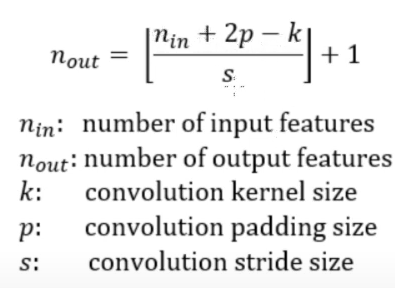

In [2]:
# using transfer learning for the CNN

VGG_model = torchvision.models.vgg16(pretrained=True) # using the pretrained weights of the model

print(VGG_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
# this class is used to omit the layer (passes on the output as is)
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
# # changing the last layers
# VGG_model.avgpool = Identity()
# VGG_model.classifier = nn.Sequential(
#     nn.Linear(512,100),
#     nn.ReLU(),
#     nn.Linear(100,10)
# )
# print(VGG_model)

In [49]:
# checking the NN

features = torch.rand(64,3,32,32) # no. of examples
output = VGG_model(features)
print(output.shape) # output should be no. of examples x num_classes

torch.Size([64, 512, 1, 1])
torch.Size([64, 10])


### Initializing hyperparams

In [4]:
# hyper params
in_channels = 1
num_classes = 10
lr = 0.001
batch_size = 64
num_epochs = 5

### Loading the dataset and creating dataloader

Also transforming the dataset to convert them to tensors before sending to the model

In [5]:
train_dataset = datasets.CIFAR10(root='../datasets/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)

test_dataset = datasets.CIFAR10(root='../datasets/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

### Initializing the network

In [8]:
# initialize the network
model = VGG_model.to(device) # sending model to device

In [9]:
from torchinfo import summary

summary(model, input_size=(len(train_loader), 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [782, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [782, 64, 32, 32]         1,792
│    └─ReLU: 2-2                         [782, 64, 32, 32]         --
│    └─Conv2d: 2-3                       [782, 64, 32, 32]         36,928
│    └─ReLU: 2-4                         [782, 64, 32, 32]         --
│    └─MaxPool2d: 2-5                    [782, 64, 16, 16]         --
│    └─Conv2d: 2-6                       [782, 128, 16, 16]        73,856
│    └─ReLU: 2-7                         [782, 128, 16, 16]        --
│    └─Conv2d: 2-8                       [782, 128, 16, 16]        147,584
│    └─ReLU: 2-9                         [782, 128, 16, 16]        --
│    └─MaxPool2d: 2-10                   [782, 128, 8, 8]          --
│    └─Conv2d: 2-11                      [782, 256, 8, 8]          29

### Initializing loss and optimizer

In [12]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

### Training the model (fine-tuning all the layers)

In [18]:
for epoch in range(num_epochs):  # 1 epoch means the model has seen all the images
    total_loss = 0
    counter = 0 
    
    n_batches = len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}')
    pbar = tf.keras.utils.Progbar(target=n_batches)
    
    # Training
    model.train()
    
    for idx, (data, target) in enumerate(train_loader):  # enumerating to see the batch idx
        
        # get data to cuda if possible
        data = data.to(device)
        target = target.to(device)
        
        # foward
        scores = model(data)  
        loss = criterion(scores, target)
        total_loss += loss
        
        pbar.update(idx, values=[("loss",loss.item())])
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        # gradient descent step
        optimizer.step()
        
        # increment for every batch
        counter += 1
        
    # for every epoch calculate test loss
    # validation
    model.eval()
    
    for idx, (data, target) in enumerate(test_loader):
        with torch.no_grad(): # no computation for gradients
            # get data to cuda
            data = data.to(device)
            target = target.to(device)

            scores = model(data)
            loss = criterion(scores, target)
            
            pbar.update(idx, values=[("validation loss",loss.item())])
    
    pbar.update(n_batches, values=None)

Epoch 1/5
782/782 [==============================] - 33s 41ms/step - loss: 1.4603 - validation loss: 1.0868
Epoch 2/5
782/782 [==============================] - 32s 41ms/step - loss: 0.7999 - validation loss: 0.7315
Epoch 3/5
782/782 [==============================] - 33s 42ms/step - loss: 0.5842 - validation loss: 0.6368
Epoch 4/5
782/782 [==============================] - 33s 42ms/step - loss: 0.4664 - validation loss: 0.5892
Epoch 5/5
782/782 [==============================] - 32s 41ms/step - loss: 0.3989 - validation loss: 0.6204


### Checking the accuracy of the model

In [14]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    output_gt = []
    output_pred = []
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1) # .max() return max value and indices
            
            output_gt.extend(y.cpu().numpy())
            output_pred.extend(predictions.cpu().numpy())
        
        if (loader.dataset.train):
            print("Training Metrics: ")
        else:
            print("Testing Metrics: ")
        print(f'Precision: {precision_score(output_gt, output_pred, average="micro")}')
        print(f'Recall: {recall_score(output_gt, output_pred, average="micro")}')
        print(f'F1_score: {f1_score(output_gt, output_pred, average="micro")}')

In [20]:
check_accuracy(train_loader, model)

Training Metrics: 
Precision: 0.89848
Recall: 0.89848
F1_score: 0.89848


In [21]:
check_accuracy(test_loader, model)

Testing Metrics: 
Precision: 0.8083
Recall: 0.8083
F1_score: 0.8083


### Training the model (fine-tuning the classification layers)

In [10]:
# freezing layers
for param in model.parameters():
    param.requires_grad = False
    
# changing the last layers
model.avgpool = Identity()
model.classifier = nn.Sequential(
    nn.Linear(512,100),
    nn.ReLU(),
    nn.Linear(100,10)
)

In [11]:
from torchinfo import summary

summary(model, input_size=(len(train_loader), 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [782, 512, 1, 1]          --
│    └─Conv2d: 2-1                       [782, 64, 32, 32]         (1,792)
│    └─ReLU: 2-2                         [782, 64, 32, 32]         --
│    └─Conv2d: 2-3                       [782, 64, 32, 32]         (36,928)
│    └─ReLU: 2-4                         [782, 64, 32, 32]         --
│    └─MaxPool2d: 2-5                    [782, 64, 16, 16]         --
│    └─Conv2d: 2-6                       [782, 128, 16, 16]        (73,856)
│    └─ReLU: 2-7                         [782, 128, 16, 16]        --
│    └─Conv2d: 2-8                       [782, 128, 16, 16]        (147,584)
│    └─ReLU: 2-9                         [782, 128, 16, 16]        --
│    └─MaxPool2d: 2-10                   [782, 128, 8, 8]          --
│    └─Conv2d: 2-11                      [782, 256, 8, 8]    

We now see that only 52,310 params are trainable

In [13]:
for epoch in range(num_epochs):  # 1 epoch means the model has seen all the images
    total_loss = 0
    counter = 0 
    
    n_batches = len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}')
    pbar = tf.keras.utils.Progbar(target=n_batches)
    
    # Training
    model.train()
    
    for idx, (data, target) in enumerate(train_loader):  # enumerating to see the batch idx
        
        # get data to cuda if possible
        data = data.to(device)
        target = target.to(device)
        
        # foward
        scores = model(data)  
        loss = criterion(scores, target)
        total_loss += loss
        
        pbar.update(idx, values=[("loss",loss.item())])
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        
        # gradient descent step
        optimizer.step()
        
        # increment for every batch
        counter += 1
        
    # for every epoch calculate test loss
    # validation
    model.eval()
    
    for idx, (data, target) in enumerate(test_loader):
        with torch.no_grad(): # no computation for gradients
            # get data to cuda
            data = data.to(device)
            target = target.to(device)

            scores = model(data)
            loss = criterion(scores, target)
            
            pbar.update(idx, values=[("validation loss",loss.item())])
    
    pbar.update(n_batches, values=None)

Epoch 1/5
782/782 [==============================] - 17s 3ms/step - loss: 1.2485 - validation loss: 1.1479
Epoch 2/5
782/782 [==============================] - 17s 21ms/step - loss: 1.0995 - validation loss: 1.1105
Epoch 3/5
782/782 [==============================] - 17s 21ms/step - loss: 1.0507 - validation loss: 1.0863
Epoch 4/5
782/782 [==============================] - 17s 21ms/step - loss: 1.0091 - validation loss: 1.0795
Epoch 5/5
782/782 [==============================] - 17s 21ms/step - loss: 0.9754 - validation loss: 1.0685


In [15]:
check_accuracy(train_loader, model)

Training Metrics: 
Precision: 0.6776
Recall: 0.6776
F1_score: 0.6776


In [16]:
check_accuracy(test_loader, model)

Testing Metrics: 
Precision: 0.6312
Recall: 0.6312
F1_score: 0.6312


Training was a bit faster then before but the model was unable to capture details from the dataset and hence underfitted.